# Hot Songs Tracker

**Team: Anna Mongillo, Hannah Melville-Rea, Christine Dah-In Chung**

This project creates a [webpage](http://ec2-52-0-84-157.compute-1.amazonaws.com:2000/) for users to be able to find information on the most popular songs and artists of the week. We scrape weekly information about the top songs from Billboard and use SongKick's API to find data on upcoming concerts for relevant artists. 



In [1]:
#Importing all the necessary packages
from bs4 import BeautifulSoup
from lxml import html 
import requests
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import MySQLdb as mdb
import re
import json
from flask import Flask, render_template
from flask import request
import io
import base64
import os
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
plt.rcParams['figure.figsize'] = (10, 5)
# matplotlib.use('Agg')
# if os.environ.get('DISPLAY','') == '':
   # print('no display found. Using non-interactive Agg backend')
import mpld3
import folium

## Scraping from Billboard Site:

In [2]:
url = "http://www.billboard.com/charts/hot-100"
page = requests.get(url)
bs = BeautifulSoup(page.text, 'html.parser')
doc = html.fromstring(page.text) # parse it and create a document

Parse through results and get list of dictionary data to insert in SQL:



In [3]:
songs = bs.findAll('div','chart-row__main-display')
data=[]
for song in songs:
    title = song.find('h2','chart-row__song').contents[0]
    featured = song.find('span','chart-row__artist') # featured artists and single artists have different html formats
    single_artist=song.find('a', 'chart-row__artist')
    rank=song.find('span', 'chart-row__current-week').contents[0]
    lastweek=song.find('span', 'chart-row__last-week').contents[0].replace('Last Week:', "")
    dates=doc.xpath('//time')
    for date in dates:
        newdate1=str(date.text)
        newdate2=pd.to_datetime(newdate1).date()
        today=datetime.strftime(newdate2, '%m/%d/%Y')
    data.append({'Title': title,
                 'Last Week Rank': lastweek,
                 'Featured Artists': featured,
                 'Single Artist': single_artist,
                 'Current Rank': rank, 'Week of': today,},)
data[0] #show example of what will go into SQL

{'Current Rank': '1', 'Featured Artists': <span class="chart-row__artist">
 Ed Sheeran Duet With Beyonce
 </span>, 'Last Week Rank': ' 1', 'Single Artist': None, 'Title': 'Perfect', 'Week of': '01/06/2018'}

Create a database:

In [4]:
con = mdb.connect(host = 'localhost', 
                  user = 'root', 
                  passwd = 'dwdstudent2015', 
                  charset='utf8', use_unicode=True);
db_name = 'billboard'
create_db_query = "CREATE DATABASE IF NOT EXISTS {db} DEFAULT CHARACTER SET 'utf8'".format(db=db_name)

cursor = con.cursor()
cursor.execute(create_db_query)
cursor.close()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: Warning: (1007, "Can't create database 'billboard'; database exists")
  if __name__ == '__main__':


Create a table:

In [5]:
cursor = con.cursor()
table_name = 'Top100'
create_table_query = '''CREATE TABLE IF NOT EXISTS {db}.{table}
                        (current_rank int,
                        last_week_rank varchar(250), 
                        featured_artists varchar(250),
                        single_artist varchar(250),
                        song_title varchar (250), 
                        week_of varchar(250),
                        PRIMARY KEY(song_title, current_rank, week_of))'''.format(db=db_name, table=table_name)
cursor.execute(create_table_query)
cursor.close()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: Warning: (1050, "Table 'Top100' already exists")
  # This is added back by InteractiveShellApp.init_path()


Add the data:

In [6]:
table_name = 'Top100'
query_template = '''INSERT IGNORE INTO {db}.{table}(current_rank, 
                                            last_week_rank,
                                            featured_artists,
                                            single_artist,
                                            song_title,
                                            week_of) 
                    VALUES (%s, %s, %s, %s, %s, %s)'''.format(db=db_name, table=table_name)
cursor = con.cursor()

for entry in data:
    current_rank = entry['Current Rank']
    last_week_rank = entry['Last Week Rank']
    featured_artists=entry['Featured Artists']
    single_artist=entry['Single Artist']
    song_title=entry['Title']
    week_of=entry['Week of']
    print("Inserting headline", title)
    query_parameters = (current_rank, last_week_rank, featured_artists, single_artist, song_title, week_of)
    cursor.execute(query_template, query_parameters)

con.commit()
cursor.close()

Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice
Inserting headline Juice


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: Warning: (1062, "Duplicate entry 'Perfect-1-01/06/2018' for key 'PRIMARY'")
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: Warning: (1062, "Duplicate entry 'Rockstar-2-01/06/2018' for key 'PRIMARY'")
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: Warning: (1062, "Duplicate entry 'Havana-3-01/06/2018' for key 'PRIMARY'")
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: Warning: (1062, "Duplicate entry 'No Limit-4-01/06/2018' for key 'PRIMARY'")
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: Warning: (1062, "Duplicate entry 'Thunder-5-01/06/2018' for key 'PRIMARY'")
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: Warning: (1062, "Duplicate entry 'Gucci Gang-6-01/06/2018' for key 'PRIMARY'")
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: Warning: (1062, "Duplicate entry 'MotorSport-7-01/06/2018' for key 'PRIMARY'")
/usr/l

Create DataFrames from SQL table:

In [7]:
cur = con.cursor(mdb.cursors.DictCursor)
cur.execute("SELECT * FROM {db}.{table}".format(db=db_name, table=table_name))
rows = cur.fetchall()
cur.close()

top100 = pd.DataFrame(list(rows)) # dataframe containing top 100 artists
top100['week_of']=pd.to_datetime(top100['week_of']) # convert week to datetime format
    
# combine featured and single artist columns and clean dataframe
top100['artist']=top100['featured_artists'].fillna(top100['single_artist']) 
elements=list(top100['artist'])
items=[str(element).replace("\n", "") for element in elements]
regex = re.compile('^.*\>(.*)\<.*$', re.DOTALL)
top100['artist']=[m.group(1) for l in items for m in [regex.search(l)] if m] 
top100['artist']=top100.artist.str.replace("amp;", "")
top100=top100.drop(['featured_artists'], axis=1).drop(['single_artist'], axis=1)

top100['last_week_rank']=["NaN" if x==' --' or x=='0' else x for x in top100['last_week_rank']]
top100['last_week_rank']=[int(x)if x!='NaN' else x for x in top100['last_week_rank']]

ordered=top100.sort_values(['week_of', 'current_rank'], ascending=[False, True], axis=0) # dataframe sorted by rank, and date
ordered.columns=['Current Rank', 'Last Week Rank', 'Song Title', 'Week','Artist']
top10plot=ordered[:10].drop(['Artist'], axis=1).drop(['Week'], axis=1) # dataframe containing top 10 artists

top10songs=[element for element in top10plot['Song Title']] #list of current top 10 songs
songs=top100.set_index('song_title').drop(['artist'], axis=1)
allsongs=[songs.loc[song] for song in top10songs] # locate top 10 songs in Top 100 df

In [12]:
top100.sort_values(['week_of', 'current_rank'], ascending=[False, True], axis=0)

,current_rank,last_week_rank,song_title,week_of,artist
591,1,1,Perfect,2018-01-06,Ed Sheeran Duet With Beyonce
676,2,2,Rockstar,2018-01-06,Post Malone Featuring 21 Savage
293,3,3,Havana,2018-01-06,Camila Cabello Featuring Young Thug
272,4,4,Gucci Gang,2018-01-06,Lil Pump
572,4,5,No Limit,2018-01-06,G-Eazy Featuring A$AP Rocky & Cardi B
574,5,10,No Limit,2018-01-06,G-Eazy Featuring A$AP Rocky & Cardi B
832,5,6,Thunder,2018-01-06,Imagine Dragons
276,6,4,Gucci Gang,2018-01-06,Lil Pump
839,6,5,Thunder,2018-01-06,Imagine Dragons
545,7,6,MotorSport,2018-01-06,"Migos, Nicki Minaj & Cardi B"


Now we have historic data for the top ten songs in a list of dataframes. This will come in handy for plotting!

In [8]:
allsongs

[            current_rank last_week_rank    week_of
 song_title                                        
 Perfect                1              1 2018-01-03
 Perfect                1              1 2018-01-06
 Perfect                1              3 2017-12-23
 Perfect                1              1 2017-12-30
 Perfect                3              5 2017-12-16
 Perfect                5              7 2017-12-09
 Perfect                7              8 2017-12-02
 Perfect                8             11 2017-11-25
 Perfect               11             10 2017-11-18,
             current_rank last_week_rank    week_of
 song_title                                        
 Rockstar               1              1 2017-11-18
 Rockstar               1              1 2017-11-25
 Rockstar               1              1 2017-12-02
 Rockstar               1              1 2017-12-09
 Rockstar               1              1 2017-12-16
 Rockstar               2              2 2018-01-03
 Rockstar  

Save Top 10 Plots as HTML templates:

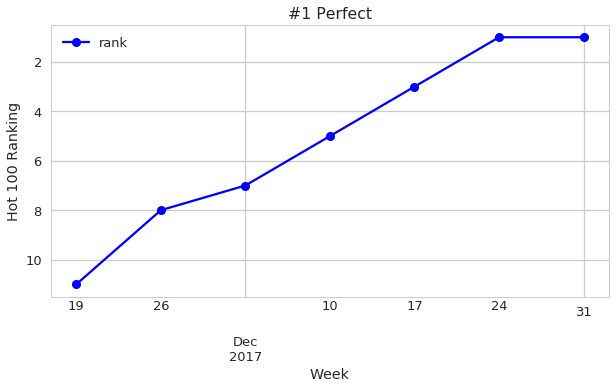

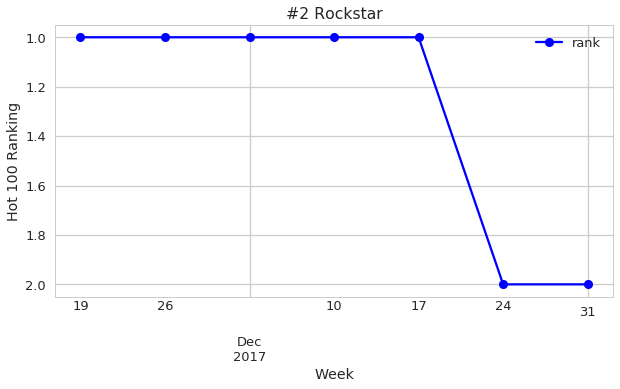

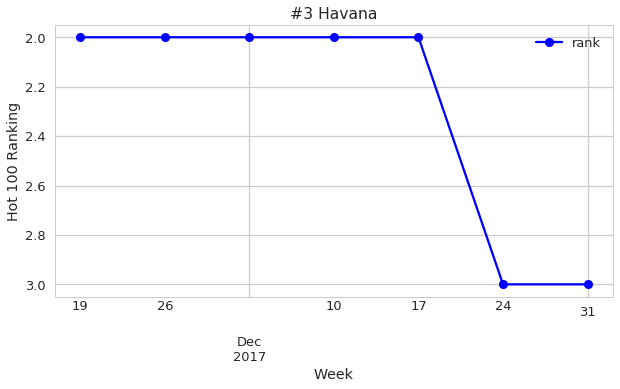

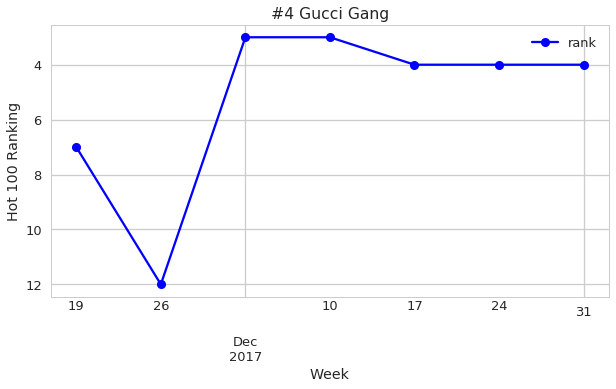

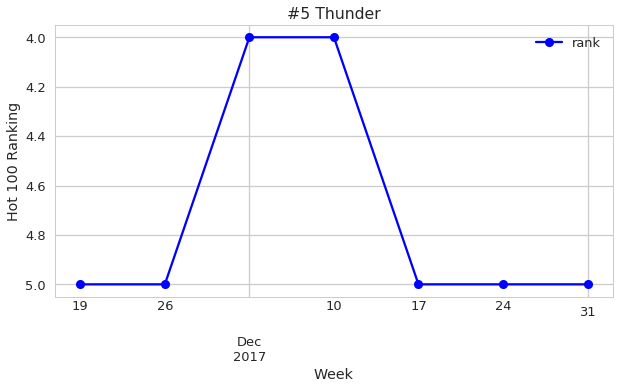

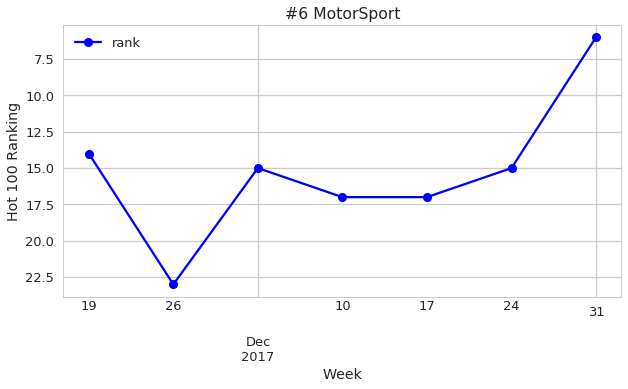

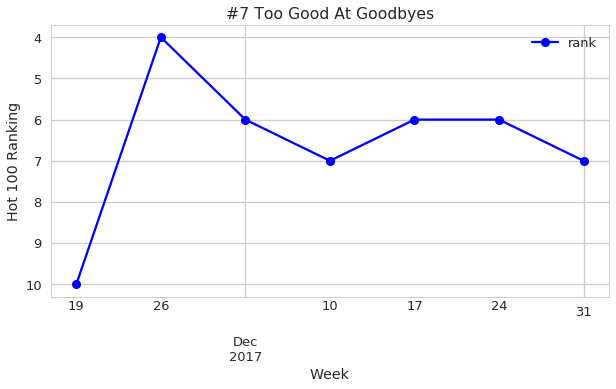

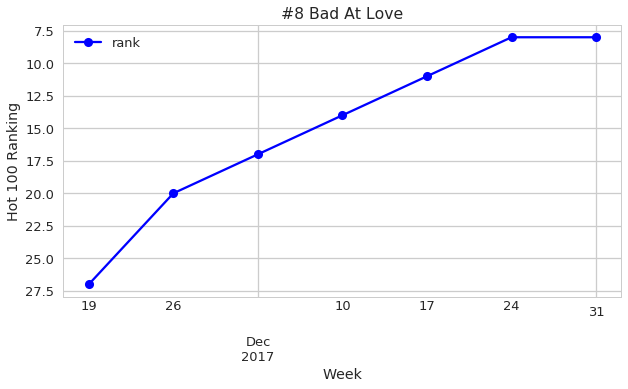

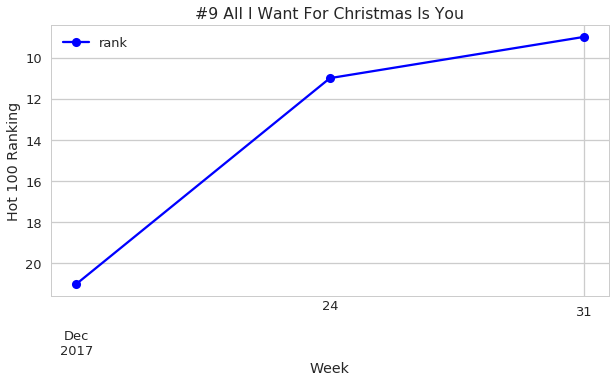

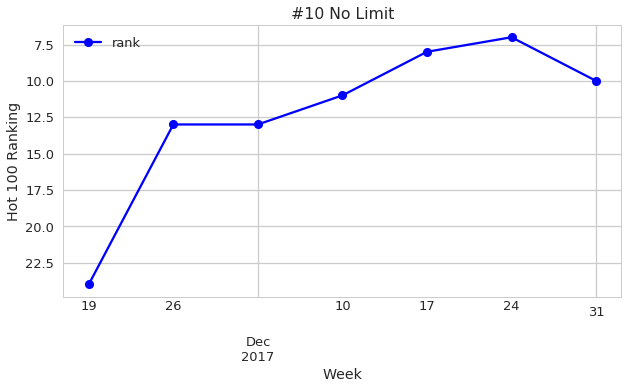

In [9]:
ax1=allsongs[0].reset_index().set_index('week_of').resample('W').sum().plot(marker="o", color='blue')
ax1.set_title('#1 '+allsongs[0].reset_index()['song_title'][0])
ax1.set_xlabel('Week')
ax1.set_ylabel('Hot 100 Ranking')
ax1.invert_yaxis()
ax1.legend(['rank'])
fig = ax1.get_figure()
mpld3.save_html(fig, "templates/plot1.html")

ax2=allsongs[1].reset_index().set_index('week_of').resample('W').sum().plot(marker="o", color='blue')
ax2.set_title('#2 '+allsongs[1].reset_index()['song_title'][0])
ax2.set_xlabel('Week')
ax2.set_ylabel('Hot 100 Ranking')
ax2.invert_yaxis()
ax2.legend(['rank'])
fig = ax2.get_figure()
mpld3.save_html(fig, "templates/plot2.html")
                
ax3=allsongs[2].reset_index().set_index('week_of').resample('W').sum().plot(marker="o", color='blue')
ax3.set_title('#3 '+allsongs[2].reset_index()['song_title'][0])
ax3.set_xlabel('Week')
ax3.set_ylabel('Hot 100 Ranking')
ax3.invert_yaxis()
ax3.legend(['rank'])
fig = ax3.get_figure()
mpld3.save_html(fig, "templates/plot3.html")
                
ax4=allsongs[3].reset_index().set_index('week_of').resample('W').sum().plot(marker="o", color='blue')
ax4.set_title('#4 '+allsongs[3].reset_index()['song_title'][0])
ax4.set_xlabel('Week')
ax4.set_ylabel('Hot 100 Ranking')
ax4.invert_yaxis()
ax4.legend(['rank'])
fig = ax4.get_figure()
mpld3.save_html(fig, "templates/plot4.html")
                
ax5=allsongs[4].reset_index().set_index('week_of').resample('W').sum().plot(marker="o", color='blue')
ax5.set_title('#5 '+allsongs[4].reset_index()['song_title'][0])
ax5.set_xlabel('Week')
ax5.set_ylabel('Hot 100 Ranking')
ax5.invert_yaxis()
ax5.legend(['rank'])
fig = ax5.get_figure()
mpld3.save_html(fig, "templates/plot5.html")            
                
ax6=allsongs[5].reset_index().set_index('week_of').resample('W').sum().plot(marker="o", color='blue')
ax6.set_title('#6 '+allsongs[5].reset_index()['song_title'][0])
ax6.set_xlabel('Week')
ax6.set_ylabel('Hot 100 Ranking')
ax6.invert_yaxis()
ax6.legend(['rank'])
fig = ax6.get_figure()
mpld3.save_html(fig, "templates/plot6.html")
                
ax7=allsongs[6].reset_index().set_index('week_of').resample('W').sum().plot(marker="o", color='blue')
ax7.set_title('#7 '+allsongs[6].reset_index()['song_title'][0])
ax7.set_xlabel('Week')
ax7.set_ylabel('Hot 100 Ranking')
ax7.invert_yaxis()
ax7.legend(['rank'])
fig = ax7.get_figure()
mpld3.save_html(fig, "templates/plot7.html")
                
ax8=allsongs[7].reset_index().set_index('week_of').resample('W').sum().plot(marker="o", color='blue')
ax8.set_title('#8 '+allsongs[7].reset_index()['song_title'][0])
ax8.set_xlabel('Week')
ax8.set_ylabel('Hot 100 Ranking')
ax8.invert_yaxis()
ax8.legend(['rank'])
fig = ax8.get_figure()
mpld3.save_html(fig, "templates/plot8.html")
                
ax9=allsongs[8].reset_index().set_index('week_of').resample('W').sum().plot(marker="o", color='blue')
ax9.set_title('#9 '+allsongs[8].reset_index()['song_title'][0])
ax9.set_xlabel('Week')
ax9.set_ylabel('Hot 100 Ranking')
ax9.invert_yaxis()
ax9.legend(['rank'])
fig = ax9.get_figure()
mpld3.save_html(fig, "templates/plot9.html")

ax10=allsongs[9].reset_index().set_index('week_of').resample('W').sum().plot(marker="o", color='blue')
ax10.set_title('#10 '+allsongs[9].reset_index()['song_title'][0])
ax10.set_xlabel('Week')
ax10.set_ylabel('Hot 100 Ranking')
ax10.invert_yaxis()
ax10.legend(['rank'])
fig = ax10.get_figure()
mpld3.save_html(fig, "templates/plot10.html")
plt.show() #example

The code above is running as a crontab script, so plots and MySQL continually updates every week.

## Saving Top 10 Song Titles and Images

We create a script that periodically runs and stores the top 10 song titles with their rank and a corresponding image of the album cover to use on our website. We scrape the billboard site for this data.

In [10]:
url = "http://www.billboard.com/charts/hot-100"
page = requests.get(url)
bs = BeautifulSoup(page.text, 'html.parser')
doc = html.fromstring(page.text) # parse it and create a document

By inspecting the html code, we find the points at which our desired information is stored.

In [11]:
# parse through results and get list of dictionary data to insert in SQL
songs = bs.findAll('div','chart-row__main-display')
data=[]
for song in songs:
    title = song.find('h2','chart-row__song').contents[0]
    dates=doc.xpath('//time')
    for date in dates:
        newdate1=str(date.text)
        newdate2=pd.to_datetime(newdate1).date()
        today=datetime.strftime(newdate2, '%m/%d/%Y')
    rank = song.find('span', 'chart-row__current-week').contents[0]
    if int(rank) > 10: #Only collect the top 10
        break
    image = song.find('div','chart-row__image')
    text = str(image)
    if text == '<div class="chart-row__image">\n</div>': #For those without an image
        text = 'https://populous.com/wp-content/uploads/2012/02/anonymous-icon.jpg' #assign anon image
    regex = re.compile(r'htt.*jpg')
    matches = regex.finditer(text)
    for match in matches:
        image_url=match.group()
    data.append({'Title': title,
                 'Image':image_url, 'Rank': rank, 'Week':today},)

We connect to SQL and create a table to store the information.

In [12]:
con = mdb.connect(host = 'localhost', 
                  user = 'root', 
                  passwd = 'dwdstudent2015', 
                  charset='utf8', use_unicode=True);
db_name = 'billboard'

In [13]:
#CREATING THE TABLE IN SQL
cursor = con.cursor()
table_name = 'ranked_top10_images'
create_table_query = '''CREATE TABLE IF NOT EXISTS {db}.{table}
                        (song_title varchar (250), 
                        image varchar(250),
                        rank varchar(250),
                        week varchar(250),
                        PRIMARY KEY(song_title, rank, week))'''.format(db=db_name, table=table_name)
cursor.execute(create_table_query)
cursor.close()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: Warning: (1050, "Table 'ranked_top10_images' already exists")
  # Remove the CWD from sys.path while we load stuff.


In [14]:
#INSERTING DATA INTO THE TABLE
table_name = 'ranked_top10_images'
query_template = '''INSERT IGNORE INTO {db}.{table}(song_title, 
                                            image, rank, week) 
                    VALUES (%s, %s, %s, %s)'''.format(db=db_name, table=table_name)
cursor = con.cursor()

for entry in data:
    song_title=entry['Title']
    image=entry['Image']
    rank=entry['Rank']
    week=entry['Week']
    print('#', rank, song_title, ':', image, week) #To show us what we are inserting
    query_parameters = (song_title, image, rank, week)
    cursor.execute(query_template, query_parameters)

con.commit()
cursor.close()

# 1 Perfect : https://charts-static.billboard.com/img/2017/03/ed-sheeran.jpg 12/30/2017
# 2 Rockstar : https://charts-static.billboard.com/img/2017/01/post-malone.jpg 12/30/2017
# 3 Havana : https://charts-static.billboard.com/img/2017/07/camila-cabello.jpg 12/30/2017
# 4 Gucci Gang : https://populous.com/wp-content/uploads/2012/02/anonymous-icon.jpg 12/30/2017
# 5 Thunder : https://charts-static.billboard.com/img/1840/12/imagine-dragons-hy6.jpg 12/30/2017
# 6 MotorSport : https://charts-static.billboard.com/img/2017/07/migos.jpg 12/30/2017
# 7 Too Good At Goodbyes : https://charts-static.billboard.com/img/1840/12/sam-smith-vv8.jpg 12/30/2017
# 8 Bad At Love : https://charts-static.billboard.com/img/2017/07/halsey.jpg 12/30/2017
# 9 All I Want For Christmas Is You : https://charts-static.billboard.com/img/2017/02/mariah-carey.jpg 12/30/2017
# 10 No Limit : https://charts-static.billboard.com/img/2017/06/geazy.jpg 12/30/2017


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: Warning: (1062, "Duplicate entry 'Perfect-1-12/30/2017' for key 'PRIMARY'")
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: Warning: (1062, "Duplicate entry 'Rockstar-2-12/30/2017' for key 'PRIMARY'")
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: Warning: (1062, "Duplicate entry 'Havana-3-12/30/2017' for key 'PRIMARY'")
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: Warning: (1062, "Duplicate entry 'Gucci Gang-4-12/30/2017' for key 'PRIMARY'")
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: Warning: (1062, "Duplicate entry 'Thunder-5-12/30/2017' for key 'PRIMARY'")
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: Warning: (1062, "Dupli

We saved the previous code as a python script and using crontab are running the script and collecting the data every week. 

Create dictionary from SQL table:

In [15]:
cur = con.cursor(mdb.cursors.DictCursor)
cur.execute("SELECT * FROM {db}.{table} ORDER BY rank".format(db=db_name, table='ranked_top10_images'))
rows = cur.fetchall()
cur.close()

imagedict=list(rows)
imagedict

[{'image': 'https://charts-static.billboard.com/img/2017/03/ed-sheeran.jpg',
  'rank': '1',
  'song_title': 'Perfect',
  'week': '12/23/2017'},
 {'image': 'https://charts-static.billboard.com/img/2017/03/ed-sheeran.jpg',
  'rank': '1',
  'song_title': 'Perfect',
  'week': '12/30/2017'},
 {'image': 'https://charts-static.billboard.com/img/2017/06/geazy.jpg',
  'rank': '10',
  'song_title': 'No Limit',
  'week': '12/30/2017'},
 {'image': 'https://charts-static.billboard.com/img/1840/12/maroon-5-9st.jpg',
  'rank': '10',
  'song_title': 'What Lovers Do',
  'week': '12/23/2017'},
 {'image': 'https://charts-static.billboard.com/img/2017/01/post-malone.jpg',
  'rank': '2',
  'song_title': 'Rockstar',
  'week': '12/23/2017'},
 {'image': 'https://charts-static.billboard.com/img/2017/01/post-malone.jpg',
  'rank': '2',
  'song_title': 'Rockstar',
  'week': '12/30/2017'},
 {'image': 'https://charts-static.billboard.com/img/2017/07/camila-cabello.jpg',
  'rank': '3',
  'song_title': 'Havana',
  '

## Concert information from SongKick API

Connect to the database that has been storing information regarding the top artists.

In [16]:
con = mdb.connect(host = 'localhost', 
                  user = 'root',
                  database = 'billboard',
                  passwd = 'dwdstudent2015', 
                  charset='utf8', use_unicode=True);
    
cur = con.cursor(mdb.cursors.DictCursor)
cur.execute("SELECT * FROM Top100")
rows = cur.fetchall()
cur.close()

In [17]:
# first convert 'rows' dictionary into dataframe to clean data more easily
top100 = pd.DataFrame(list(rows))
top100['week_of'] = pd.to_datetime(top100['week_of'])

# combine two sets of artist data
top100['artist'] = top100['featured_artists'].fillna(top100['single_artist'])

In [18]:
# use regular expressions to clean artist data to get just the artist's name
elements=list(top100['artist'])
items=[str(element).replace("\n", "") for element in elements]
regex = re.compile('^.*\>(.*)\<.*$', re.DOTALL)
top100['artist']=[m.group(1) for l in items for m in [regex.search(l)] if m] 
top100['artist']=top100.artist.str.replace("amp;", "") 
top100=top100.drop(['featured_artists'], axis=1).drop(['single_artist'], axis=1)

#order the dataframe by week and rank to get most current top 100
ordered=top100.sort_values(['week_of', 'current_rank'], ascending=[False, True], axis=0) 
ordered=ordered[:99].drop(['last_week_rank'], axis=1)
ordered=ordered[['current_rank', 'song_title', 'artist', 'week_of']]
for week in ordered['week_of']:
    ordered['week_of']=datetime.strftime(week, '%m/%d/%Y')
orderdict=ordered.to_dict(orient='records')
topartists=[artist['artist'] for artist in orderdict]
topartists # list of top 100 artists

['Ed Sheeran Duet With Beyonce',
 'Post Malone Featuring 21 Savage',
 'Camila Cabello Featuring Young Thug',
 'Lil Pump',
 'Imagine Dragons',
 'Migos, Nicki Minaj & Cardi B',
 'Sam Smith',
 'Halsey',
 'Mariah Carey',
 'G-Eazy Featuring A$AP Rocky & Cardi B',
 'Cardi B',
 '6ix9ine',
 'Maroon 5 Featuring SZA',
 'Dua Lipa',
 'Gucci Mane Featuring Migos',
 'NF',
 'Portugal. The Man',
 'Demi Lovato',
 'Post Malone',
 'J Balvin & Willy William Featuring Beyonce',
 'Selena Gomez X Marshmello ',
 'Logic Featuring Alessia Cara & Khalid',
 'Ed Sheeran',
 'Lil Uzi Vert Featuring Nicki Minaj',
 'Kendrick Lamar Featuring Zacari',
 'G-Eazy & Halsey',
 '21 Savage',
 'Bebe Rexha & Florida Georgia Line',
 'Charlie Puth',
 'Marshmello Featuring Khalid',
 'Luis Fonsi & Daddy Yankee Featuring Justin Bieber',
 'Khalid',
 'Imagine Dragons',
 'Brenda Lee ',
 'Andy Williams',
 'Miguel Featuring Travis Scott',
 'Taylor Swift',
 'Nat King Cole',
 'SZA',
 'French Montana Featuring Swae Lee',
 'Burl Ives',
 'Char

Now that we have a list of the artist names per song, we want to use regular experessions to separate the artist names that have two artists (e.g. "Post Malone Featuring 21 Savage" from each other.

In [19]:
results=[]
for artist in topartists:
    # Split based on & and ,
    separated =re.split(r'([\w\-\$\.!\* ]+)', artist)
    
    # We are still going to have a few pairs, joined by "Featuring"
    for a in separated:
        if "Featuring" in a:
            regex=re.compile(r'([\w\-\$&,\.!\* ]+)(?: Featuring )([\w\-\$&,\.!\* ]+)')
            matches=regex.finditer(a)
            for match in matches:
                results.append(match.group(1))
                results.append(match.group(2))
        else:
            results.append(a)
 
    
newartists=sorted(set([r.strip() for r in results if ',' not in r and '&' not in r]))
newartists

['',
 '21 Savage',
 '6ix9ine',
 'A Boogie Wit da Hoodie',
 'A$AP Ferg',
 'A$AP Rocky',
 'Alessia Cara',
 'Alesso',
 'Andy Williams',
 'BTS',
 'Bad Bunny',
 'Bebe Rexha',
 'Becky G',
 'Beyonce',
 'Big Sean',
 'Blake Shelton',
 'Brenda Lee',
 'Brett Young',
 'Bruno Mars',
 'Burl Ives',
 'Camila Cabello',
 'Cardi B',
 'Charlie Puth',
 'Chris Brown',
 'Chris Young',
 'Daddy Yankee',
 'Demi Lovato',
 'Desiigner',
 'Devin Dawson',
 'Dua Lipa',
 'Ed Sheeran',
 'Ed Sheeran Duet With Beyonce',
 'Eminem',
 'Eric Church',
 'Famous Dex',
 'Florida Georgia Line',
 'French Montana',
 'Future',
 'G-Eazy',
 'Gucci Mane',
 'Hailee Steinfeld',
 'Halsey',
 'Imagine Dragons',
 'J Balvin',
 'Justin Bieber',
 'Kelsea Ballerini',
 'Kendrick Lamar',
 'Kesha',
 'Khalid',
 'Kodak Black',
 'LANCO',
 'Lil Baby',
 'Lil Pump',
 'Lil Uzi Vert',
 'Lil Wayne',
 'Lil Xan',
 'Logic',
 'Luis Fonsi',
 'Luke Bryan',
 'Luke Combs',
 'MAX',
 'Macklemore',
 'Maren Morris',
 'Mariah Carey',
 'Maroon 5',
 'Marshmello',
 'Metro 

Now that we have a clean list of individual artists, we can use the SongKick API to find their artist ID, which can then be used to find additional information on the artist's upcoming live performances through SongKick. 

In [20]:
#Function to find the artist ID from SongKick
def get_artist_pair(artistname):
    '''
    Returns the ID of the top matching artist
    WARNING: Need to check if no results come back.
    '''
    url = "http://api.songkick.com/api/3.0/search/artists.json"
    params = {
        "apikey": "dNQoOibx7TGUf7tU",
        "query": '{'+artistname+'}'
    }
    resp=requests.get(url, params = params)
    data = resp.json()

    if data['resultsPage']['totalEntries']>0:
        return {data['resultsPage']['results']['artist'][0]['id']:artistname}
    else:
        return None

In [21]:
#Execute the function above for the artist names stored--be patient, it takes a while
pairs=[get_artist_pair(artistname) for artistname in newartists]
pairs = list(filter(None, pairs))

Create a large dictionary with the keys as the ID and value as the artist's name. This will be useful to call back the artist's name in later stages. 

In [22]:
name_id = {}
for i in pairs:
    name_id.update(i)

#Save a list of just the artist IDs
ids = list(name_id.keys())

Now that we have a list of the artist IDs, we can plug it in to the SongKick API to find event information.

In [23]:
#Function to capture the upcoming concerts for each artist
def get_artist_info(i):
    '''
    Returns the ID of the top matching artist
    WARNING: Need to check if no results come back.
    '''
    url = "http://api.songkick.com/api/3.0/artists/"+str(i)+"/calendar.json"
    params = {
        "apikey": "dNQoOibx7TGUf7tU"
    }
    resp=requests.get(url, params = params)
    data = resp.json()
    if data['resultsPage']['status']=='ok':
        return {i:data['resultsPage']['results']}
    else:
        return None

In [24]:
#Execute the above function--be patient, it takes a while
info=[get_artist_info(i) for i in ids]
#Save the information all into one dictionary where the artist IDs are the keys
id_events = {}
for i in info:
    id_events.update(i)

Now we want to save each characteristic in separate lists so that we can combine them as columns in a dataframe. While the SongKick API gives us all upcoming concerts for each artist, we save only the next upcoming concert. 

In [25]:
artistid = []
artistname = []
venue = []
eventname = []
city = []
lat = []
long = []
date = []
url = []
identifier = []

empty={}
for i in id_events.keys():
    if id_events[i] != empty: #Filter out artist without upcoming concerts
        artistid.append(str(i))
        artistname.append(name_id[i]) #find artist name from saved dictionary
        
        #Filtering through the event information:
        #We choose the event [0] to get only the most recent concert information
        venue.append(id_events[i]['event'][0]['venue']['displayName'])
        eventname.append(id_events[i]['event'][0]['displayName'])
        city.append(id_events[i]['event'][0]['location']['city'])
        lat.append(id_events[i]['event'][0]['location']['lat'])
        long.append(id_events[i]['event'][0]['location']['lng'])
        date.append(id_events[i]['event'][0]['start']['date'])
        url.append(id_events[i]['event'][0]['uri'])
        identifier.append(id_events[i]['event'][0]['id']) 
        

With Pandas, we can observe how our saved data looks as a dataframe. 

In [26]:
eventinfo = pd.DataFrame(
    {'date': date,
     'venue': venue,
     'event': eventname,
     'city': city,
     'lat':lat,
     'lon': long,
     'date': date,
     'url': url,
     'id': identifier,
     'artist': artistname,
     'artistid':artistid
    })
eventinfo.head()

,artist,artistid,city,date,event,id,lat,lon,url,venue
0,Marshmello,8613384,"Edmonton, AB, Canada",2017-12-27,"Cash Cash, Malaa, Tchami, Rezz, and 6 more… at...",31437774,53.541740,-113.486775,http://www.songkick.com/concerts/31437774-cash...,Shaw Conference Centre
1,A$AP Ferg,5612553,"Los Angeles, CA, US",2017-12-31,A$AP Ferg and Jacquees at Tiffany's on Vine (D...,32212149,34.099448,-118.326666,http://www.songkick.com/concerts/32212149-asap...,Tiffany's on Vine
2,Cardi B,8962314,"Southaven, MS, US",2017-12-28,Cardi B and Migos at Landers Center (December ...,31953344,34.931985,-89.996988,http://www.songkick.com/concerts/31953344-card...,Landers Center
3,Blake Shelton,565207,"Tulsa, OK, US",2018-02-15,"Trace Adkins, Carly Pearce, Blake Shelton, and...",31763934,36.152764,-95.996227,http://www.songkick.com/concerts/31763934-trac...,BOK Center
4,Yo Gotti,385292,"San Diego, CA, US",2017-12-23,"Migos with Yo Gotti, G-Eazy, and Ty Dolla $ign...",31906989,32.755077,-117.211794,http://www.songkick.com/concerts/31906989-migo...,Valley View Casino Center


We are also going to want to visualize this in a map, so that users can zoom into a city and see if any artists are playing their next concert there. We want the artists who are ranked in the top 25 artists on Billboard's Top 100 Artists chart to stand out, so we have them marked in red while the others are marked in blue. So now we scrape the Billboard Top 100 Artists and combine it with the event dataframe:

In [27]:
# SCRAPING
url = "https://www.billboard.com/charts/artist-100"
page = requests.get(url)
bs = BeautifulSoup(page.text, 'html.parser')
topartists = bs.findAll('div','chart-row__main-display')

data=[]
for a in topartists:
    artists1=a.find('a', 'chart-row__artist')
    moreartists=a.find('span', 'chart-row__artist')
    rank=a.find('span', 'chart-row__current-week').contents[0]
    data.append({'artists1': artists1,
                 'moreartists': moreartists,
                 'rank':rank},)
artistranks=pd.DataFrame(data) # this dataframe is messy because we have not yet done a regular expression

# COMBINE
artistranks['artist']=artistranks['artists1'].fillna(artistranks['moreartists']) 
elements=list(artistranks['artist'])
items=[str(element).replace("\n", "") for element in elements]
regex = re.compile('^.*\>(.*)\<.*$', re.DOTALL) # clean the dataframe with the regular expression
artistranks['artist']=[m.group(1) for l in items for m in [regex.search(l)] if m]
artistranks=artistranks.drop(['artists1', 'moreartists'], axis=1)
total=pd.merge(artistranks, eventinfo, on='artist', how='right').fillna(0) # merge rankings with event info
total['rank']=[int(rank) for rank in total['rank']]
total.head()

,rank,artist,artistid,city,date,event,id,lat,lon,url,venue
0,1,Ed Sheeran,2083334,"Burswood, WA, Australia",2018-03-02,"Ed Sheeran at Optus Stadium (March 2, 2018)",32121454,-31.954385,115.895367,http://www.songkick.com/concerts/32121454-ed-s...,Optus Stadium
1,2,Taylor Swift,217815,"Glendale, AZ, US",2018-05-08,Taylor Swift at University of Phoenix Stadium ...,31894669,33.527960,-112.264116,http://www.songkick.com/concerts/31894669-tayl...,University of Phoenix Stadium
2,4,Luke Bryan,368352,"Riviera Maya, Mexico",2018-01-18,Luke Bryan's Crash My Playa 2018,30397744,20.553629,-87.167041,http://www.songkick.com/festivals/1677219-luke...,Unknown venue
3,5,Post Malone,8508053,"Mangawhai, New Zealand",2017-12-29,Northern Bass Festival 2017,30862674,-36.126200,174.574000,http://www.songkick.com/festivals/863984-north...,Northern Bass
4,6,Imagine Dragons,2506696,"Kuala Lumpur, Malaysia",2018-01-06,"Imagine Dragons at Malawati Indoor Stadium, Sh...",31472019,3.166670,101.700000,http://www.songkick.com/concerts/31472019-imag...,"Malawati Indoor Stadium, Shah Alam"


Use Folium to create the map:

In [28]:
import folium
fmap = folium.Map(location=[15, 10], zoom_start=2,  tiles='cartodbpositron')
for name, row in total.iterrows():
    
    color = 'red' if row['rank']in range(1,26) else 'blue' # if the artist in question is ranked 10 or above, mark as red
    
    html = "<p style='font-family:sans-serif;font-size:11px'>" + \
           "<strong>Artist: </strong>" + row["artist"] + \
           "<br><strong>City: </strong>" + row["city"] + \
            "<br><strong>Date: </strong>" +str(row["date"]) +\
            "<br><a href="+row['url'] +" target=\"_blank\">Event URL</a>"
    iframe = folium.IFrame(html=html, width=200, height=100)
    popup = folium.Popup(iframe, max_width=200)

    # create markers and popups on the map
    folium.CircleMarker(location=[row["lat"], row["lon"]], 
                        radius = 5,
                        popup=popup,
                        fill=True,
                        fill_color=color,
                        fill_opacity=0.7).add_to(fmap)
    
fmap.save('templates/map.html')
fmap

## Create Flask Homepage:

In [29]:
app = Flask(__name__)

@app.route("/")
def home():
    con = mdb.connect(host = 'localhost', 
                  user = 'root',
                  database = 'billboard',
                  passwd = 'dwdstudent2015', 
                  charset='utf8', use_unicode=True);
    
    # top 10!
    cur = con.cursor(mdb.cursors.DictCursor)
    cur.execute("SELECT * FROM Top100 where current_rank between 1 and 10 order by week_of, current_rank")
    rows = cur.fetchall()
    cur.close()
    
    rows=rows[-10:]
    top10 = pd.DataFrame(list(rows)) # first convert 'rows' dictionary into dataframe to clean data more easily
    top10['week_of']=pd.to_datetime(top10['week_of'])
    top10['artist']=top10['featured_artists'].fillna(top10['single_artist']) # combine two sets of artist data
    
    elements=list(top10['artist'])
    items=[str(element).replace("\n", "") for element in elements]
    regex = re.compile('^.*\>(.*)\<.*$', re.DOTALL)
    top10['artist']=[m.group(1) for l in items for m in [regex.search(l)] if m] 
    top10['artist']=top10.artist.str.replace("amp;", "") # clean artist data to get just artist name
    top10=top10.drop(['featured_artists'], axis=1).drop(['single_artist'], axis=1)
    for week in top10['week_of']:
        top10['week_of']=datetime.strftime(week, '%m/%d/%Y')
    top10dict=top10.to_dict(orient='records') # convert back into dictionary to plot as table
    
    # top 100!
    cur = con.cursor(mdb.cursors.DictCursor)
    cur.execute("SELECT * FROM Top100")
    rows = cur.fetchall()
    cur.close()
    
    top100 = pd.DataFrame(list(rows)) # first convert 'rows' dictionary into dataframe to clean data more easily
    top100['week_of']=pd.to_datetime(top100['week_of'])
    top100['artist']=top100['featured_artists'].fillna(top100['single_artist']) # combine two sets of artist data
    
    elements=list(top100['artist'])
    items=[str(element).replace("\n", "") for element in elements]
    regex = re.compile('^.*\>(.*)\<.*$', re.DOTALL)
    top100['artist']=[m.group(1) for l in items for m in [regex.search(l)] if m] 
    top100['artist']=top100.artist.str.replace("amp;", "") # clean artist data to get just artist name
    top100=top100.drop(['featured_artists'], axis=1).drop(['single_artist'], axis=1)
    
    ordered=top100.sort_values(['week_of', 'current_rank'], ascending=[False, True], axis=0) # order by date and current rank
    ordered=ordered[:100].drop(['last_week_rank'], axis=1)
    ordered=ordered[['current_rank', 'song_title', 'artist', 'week_of']]
    for week in ordered['week_of']:
        ordered['week_of']=datetime.strftime(week, '%m/%d/%Y')
    orderdict=ordered.to_dict(orient='records') # convert back into dictionary to plot as table
    
    # top 10 images (ordered by week and rank)!
    cur = con.cursor(mdb.cursors.DictCursor)
    cur.execute("SELECT * FROM ranked_top10_images ORDER BY week DESC, rank ASC")
    rows = cur.fetchall()
    cur.close()
    imagedict=list(rows[:10])
    
    return render_template("index.html", top10dict=top10dict, orderdict=orderdict, imagedict=imagedict)

@app.route("/plot1.html")
def plot1():
    return render_template("plot1.html")

@app.route("/plot2.html")
def plot2():
    return render_template("plot2.html")

@app.route("/plot3.html")
def plot3():
    return render_template("plot3.html")

@app.route("/plot4.html")
def plot4():
    return render_template("plot4.html")

@app.route("/plot5.html")
def plot5():
    return render_template("plot5.html")

@app.route("/plot6.html")
def plot6():
    return render_template("plot6.html")

@app.route("/plot7.html")
def plot7():
    return render_template("plot7.html")

@app.route("/plot8.html")
def plot8():
    return render_template("plot8.html")

@app.route("/plot9.html")
def plot9():
    return render_template("plot9.html")

@app.route("/plot10.html")
def plot10():
    return render_template("plot10.html")

@app.route("/map.html")
def showmap():
    return render_template("map.html")

Run Flask App:

```if __name__ == "__main__":
    app.run(host='0.0.0.0', port=2000, debug=True)```